In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.manifold import TSNE
import seaborn as sns


### Dataset

In [48]:
# Helper Functions

def find_correct_root(start_path):
    for root, dirs, files in os.walk(start_path):
        if len(dirs) > 1:
            return root
    return start_path

In [49]:
import kagglehub

path = kagglehub.dataset_download("unclesamulus/blood-cells-image-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/franciscosilva/.cache/kagglehub/datasets/unclesamulus/blood-cells-image-dataset/versions/2


In [ ]:
def get_dataloaders(data_dir, batch_size=32, img_size=128):

    data_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        # Normalization
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) 
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    
    loader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2
    )
    
    return loader, dataset.class_to_idx

In [50]:
correct_path = find_correct_root(path)
print(f"Corrected Path: {correct_path}")

loader, class_map = get_dataloaders(correct_path)
print(f"Class Mapping: {class_map}")

Corrected Path: /home/franciscosilva/.cache/kagglehub/datasets/unclesamulus/blood-cells-image-dataset/versions/2/bloodcells_dataset
Class Mapping: {'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}


In [51]:
def summarize_dataset(root_path):
    data = []
    for root, dirs, files in os.walk(root_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff')):
                label = os.path.basename(root)
                full_path = os.path.join(root, file)
                data.append({'path': full_path, 'label': label})

    df = pd.DataFrame(data)
    
    stats = df['label'].value_counts().reset_index()
    stats.columns = ['Cell Type', 'Count']
    
    return df, stats

def plot_samples(df, num_samples=5):
    plt.figure(figsize=(15, 5))
    samples = df.sample(num_samples)
    
    for i, (idx, row) in enumerate(samples.iterrows()):
        img = plt.imread(row['path'])
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(row['label'])
        plt.axis('off')
    plt.show()

In [52]:
df, stats = summarize_dataset(correct_path)

print("--- Dataset Head ---")
print(df.head())

print("\n--- Class Distribution ---")
print(stats)

--- Dataset Head ---
                                                path         label
0  /home/franciscosilva/.cache/kagglehub/datasets...  erythroblast
1  /home/franciscosilva/.cache/kagglehub/datasets...  erythroblast
2  /home/franciscosilva/.cache/kagglehub/datasets...  erythroblast
3  /home/franciscosilva/.cache/kagglehub/datasets...  erythroblast
4  /home/franciscosilva/.cache/kagglehub/datasets...  erythroblast

--- Class Distribution ---
      Cell Type  Count
0    neutrophil   3329
1    eosinophil   3117
2            ig   2895
3      platelet   2348
4  erythroblast   1551
5      monocyte   1420
6      basophil   1218
7    lymphocyte   1214


In [53]:
print(f"Class Mapping: {class_map}")
images, labels = next(iter(loader))
print(f"Batch Tensor Shape: {images.shape}")
print(f"Batch Labels: {labels}")

Class Mapping: {'basophil': 0, 'eosinophil': 1, 'erythroblast': 2, 'ig': 3, 'lymphocyte': 4, 'monocyte': 5, 'neutrophil': 6, 'platelet': 7}
Batch Tensor Shape: torch.Size([32, 3, 128, 128])
Batch Labels: tensor([6, 4, 6, 6, 1, 5, 6, 6, 0, 2, 7, 4, 2, 1, 3, 1, 3, 3, 1, 2, 7, 5, 3, 5,
        1, 1, 3, 7, 6, 3, 5, 3])


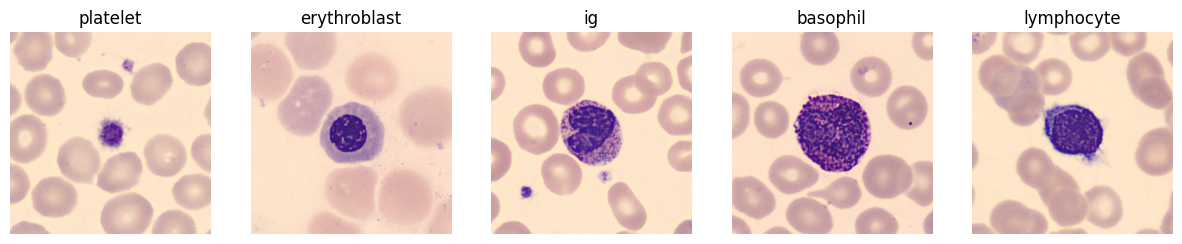

In [54]:
plot_samples(df)

### Model

In [74]:
class HematologyVAE(nn.Module):
    def __init__(self, latent_dim=128, input_channels=3):
        super(HematologyVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            self._conv_block(input_channels, 32), 
            self._conv_block(32, 64),            
            self._conv_block(64, 128),         
            self._conv_block(128, 256),           
            nn.Flatten()
        )
        
        # Latent space distribution parameters
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            self._deconv_block(256, 128),         
            self._deconv_block(128, 64),          
            self._deconv_block(64, 32),           
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()                          
        )

    def _conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU()
        )

    def _deconv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        return self.decoder(self.decoder_input(z).view(-1, 256, 8, 8)), mu, logvar

# def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
#     recon_loss = F.mse_loss(recon_x, x, reduction='sum')
#     # KL Divergence
#     kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return recon_loss + beta * kld_loss

def vae_sparse_loss(recon_x, x, mu, logvar, beta=1.0, l1_lambda=1e-4):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    l1_loss = torch.norm(mu, p=1) 
    return recon_loss + (beta * kld_loss) + (l1_lambda * l1_loss)

class VAETrainer:
    def __init__(self, model, optimizer, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device

    def train_epoch(self, loader):
        self.model.train()
        total_loss = 0
        for batch_idx, (data, _) in enumerate(loader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            
            recon_batch, mu, logvar = self.model(data)
            #loss = vae_loss_function(recon_batch, data, mu, logvar)
            # standard loss
            loss = vae_sparse_loss(recon_batch, data, mu, logvar)
            #sparse loss
            
            loss.backward()
            total_loss += loss.item()
            self.optimizer.step()
            
        return total_loss / len(loader.dataset)

### Run

In [55]:
# 1. Initialize Model
latent_dim = 128
model = HematologyVAE(latent_dim=latent_dim, input_channels=3)

# 2. Setup Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3. Initialize Trainer Class
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = VAETrainer(model, optimizer, device=device)

# 4. Training Loop
num_epochs = 25
print(f"Training started on {device}...")

for epoch in range(1, num_epochs + 1):
    avg_loss = trainer.train_epoch(loader)
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{num_epochs}] | Average Loss: {avg_loss:.4f}")
        
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"vae_hematology_epoch_{epoch}.pth")

print("Training Complete!")

Training started on cuda...
Epoch [1/25] | Average Loss: 1922.9406
Epoch [5/25] | Average Loss: 1078.0702
Epoch [10/25] | Average Loss: 1013.2642
Epoch [15/25] | Average Loss: 983.8354
Epoch [20/25] | Average Loss: 961.9519
Epoch [25/25] | Average Loss: 947.2751
Training Complete!


In [ ]:
#sparse loss
# 1. Initialize Model
latent_dim = 128
model = HematologyVAE(latent_dim=latent_dim, input_channels=3)

# 2. Setup Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 3. Initialize Trainer Class
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainer = VAETrainer(model, optimizer, device=device)

# 4. Training Loop
num_epochs = 25
print(f"Training started on {device}...")

for epoch in range(1, num_epochs + 1):
    avg_loss = trainer.train_epoch(loader)
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch [{epoch}/{num_epochs}] | Average Loss: {avg_loss:.4f}")
        
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"vae_hematology_epoch_{epoch}.pth")

print("Training Complete!")

Training started on cuda...
Epoch [1/25] | Average Loss: 1999.3499
Epoch [5/25] | Average Loss: 1078.9463
Epoch [10/25] | Average Loss: 1014.0838
Epoch [15/25] | Average Loss: 984.8475
Epoch [20/25] | Average Loss: 962.3630
Epoch [25/25] | Average Loss: 946.8679
Training Complete!


### Generate Samples

In [23]:
def generate_cells(model, num_samples=8):
    model.eval()
    with torch.no_grad():
        # Sample random vectors
        z = torch.randn(num_samples, latent_dim).to(device)
        # Decode
        samples = model.decoder(model.decoder_input(z).view(-1, 256, 8, 8))
        plt.figure(figsize=(15, 3))
        for i in range(num_samples):
            img = samples[i].cpu().permute(1, 2, 0).numpy()
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.show()

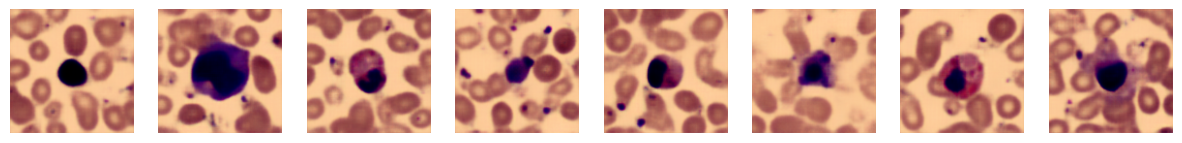

In [56]:
generate_cells(model, num_samples=8)

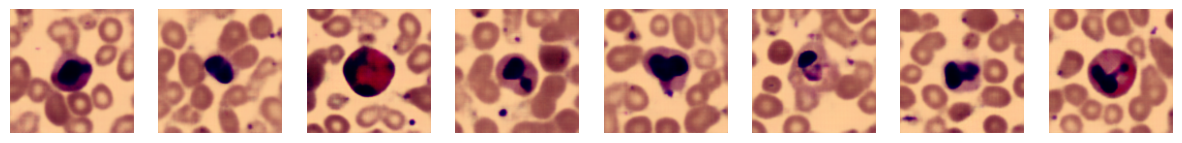

In [ ]:
#sparse loss
generate_cells(model, num_samples=8)

### Evaluation

In [26]:
def get_assessment_data(model, loader, device='cuda'):
    model.eval()
    all_mu = []
    all_labels = []
    all_paths = [path for path, label in loader.dataset.samples]

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            # Use the encoder to get the mean of the distribution (mu)
            encoded = model.encoder(images)
            mu = model.fc_mu(encoded)
            
            all_mu.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.vstack(all_mu), np.concatenate(all_labels), all_paths

In [77]:
latents, labels, file_paths = get_assessment_data(model, loader)

In [ ]:
from sklearn.neighbors import NearestNeighbors

def quality_control(latents, labels, k=10):
    # Find the k-nearest neighbors for every point in the latent space
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(latents)
    distances, indices = nbrs.kneighbors(latents)
    
    suspicion_scores = []
    
    for i in range(len(labels)):
        # Get labels of the neighbors
        neighbor_labels = labels[indices[i][1:]]
        # Calculate what percentage of neighbors have a DIFFERENT label
        mismatch_rate = np.mean(neighbor_labels != labels[i])
        suspicion_scores.append(mismatch_rate)
        
    return np.array(suspicion_scores)

In [78]:
scores = quality_control(latents, labels)

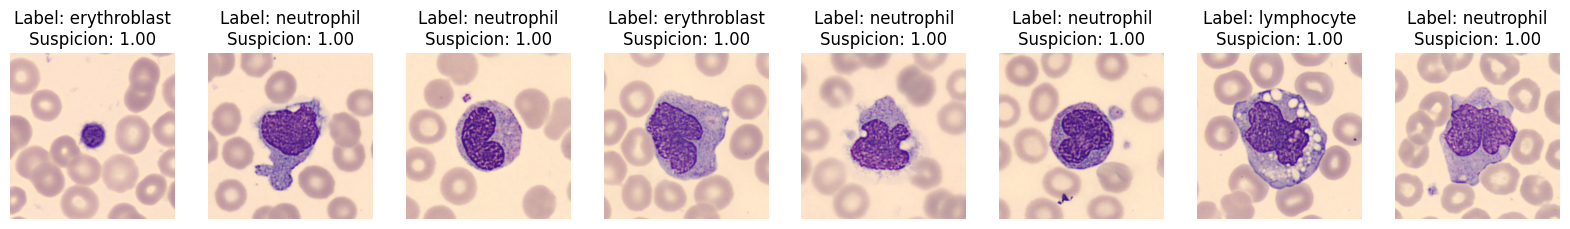

In [70]:
def plot_anomalies(file_paths, labels, scores, class_map, n=5):
    top_indices = np.argsort(scores)[::-1][:n]
    inv_class_map = {v: k for k, v in class_map.items()}

    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(top_indices):
        img = plt.imread(file_paths[idx])
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {inv_class_map[labels[idx]]}\nSuspicion: {scores[idx]:.2f}")
        plt.axis('off')
    plt.show()

plot_anomalies(file_paths, labels, scores, class_map, n=8)

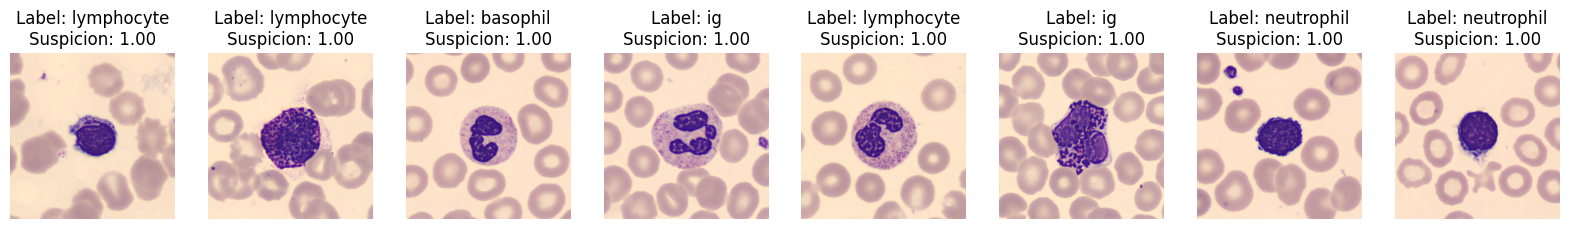

In [ ]:
#sparse loss
plot_anomalies(file_paths, labels, scores, class_map, n=8)

### Visualization

In [ ]:
def plot_tsne(latents, labels, class_map):
    
    print("Running t-SNE")
    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
    latents_2d = tsne.fit_transform(latents)
    
    inv_class_map = {v: k for k, v in class_map.items()}
    df_tsne = pd.DataFrame({
        'x': latents_2d[:, 0],
        'y': latents_2d[:, 1],
        'Cell Type': [inv_class_map[l] for l in labels]
    })
    
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        data=df_tsne, 
        x='x', y='y', 
        hue='Cell Type', 
        palette='hls', 
        alpha=0.6,
        s=50
    )
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.tight_layout()
    plt.show()

Running t-SNE


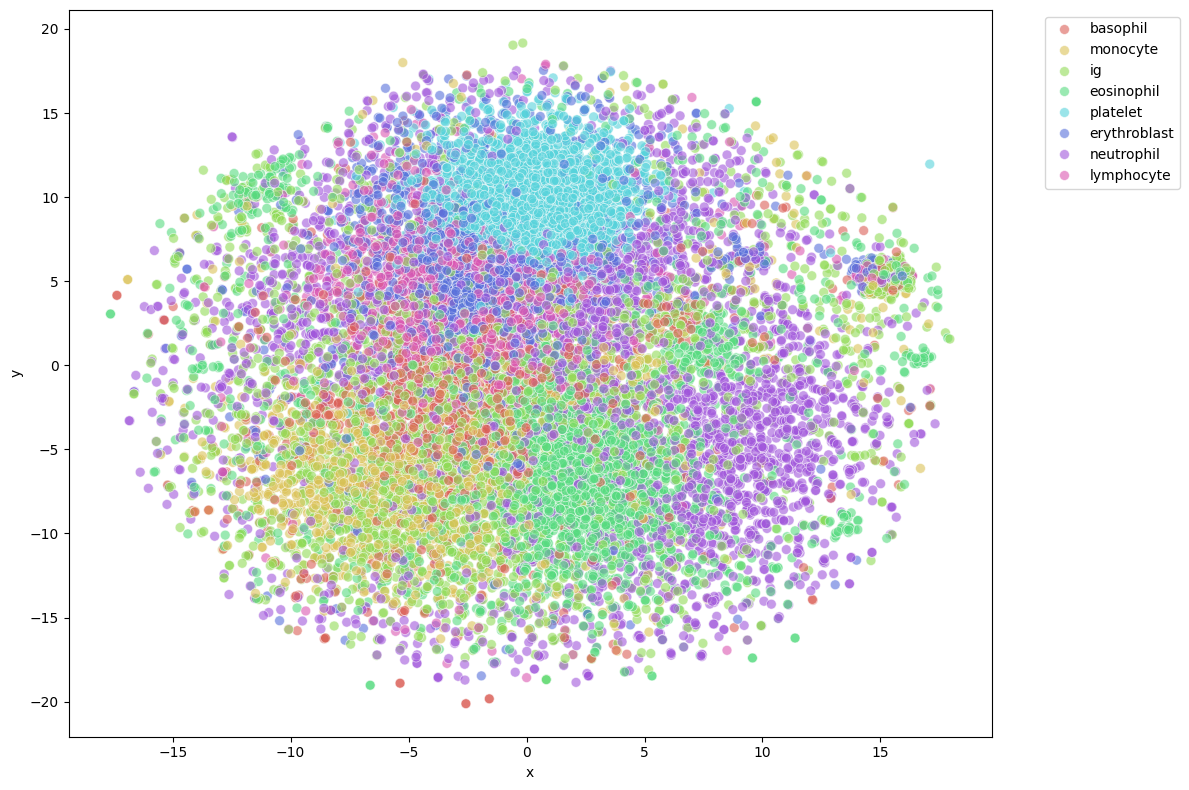

In [65]:
plot_tsne(latents, labels, class_map)

Running t-SNE


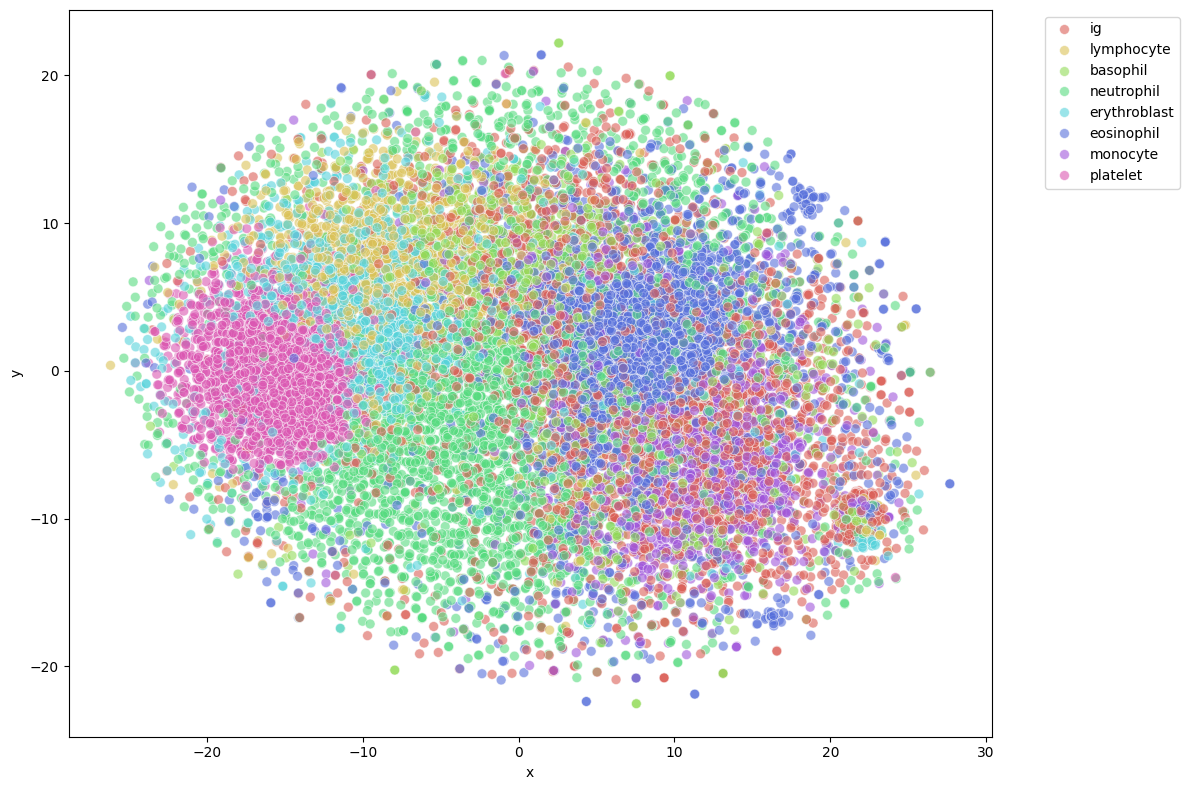

In [ ]:
#sparse loss
plot_tsne(latents, labels, class_map)

In [73]:
def compute_ood(latents, labels, file_paths, class_map, threshold=0.8):
    scores = quality_control(latents, labels, k=15)
    inv_class_map = {v: k for k, v in class_map.items()}
    
    report_data = []
    for i in range(len(scores)):
        if scores[i] >= threshold:
            report_data.append({
                'Filename': os.path.basename(file_paths[i]),
                'Assigned_Label': inv_class_map[labels[i]],
                'Suspicion_Score': round(scores[i], 2),
                'Full_Path': file_paths[i]
            })
    
    report_df = pd.DataFrame(report_data).sort_values(by='Suspicion_Score', ascending=False)
    return report_df

report = compute_ood(latents, labels, file_paths, class_map)
print(f"Total images flagged for review: {len(report)}")
print(report.head(10))

Total images flagged for review: 7212
            Filename Assigned_Label  Suspicion_Score  \
0      BA_100102.jpg       basophil              1.0   
2930  MMY_891309.jpg             ig              1.0   
3049   MY_223749.jpg     lymphocyte              1.0   
3045   MY_218573.jpg       monocyte              1.0   
3016   MY_167589.jpg             ig              1.0   
3010      MY_161.jpg     neutrophil              1.0   
3003   MY_147920.jpg             ig              1.0   
2985   MY_116737.jpg     neutrophil              1.0   
2974  MMY_986095.jpg     neutrophil              1.0   
2970  MMY_979454.jpg             ig              1.0   

                                              Full_Path  
0     /home/franciscosilva/.cache/kagglehub/datasets...  
2930  /home/franciscosilva/.cache/kagglehub/datasets...  
3049  /home/franciscosilva/.cache/kagglehub/datasets...  
3045  /home/franciscosilva/.cache/kagglehub/datasets...  
3016  /home/franciscosilva/.cache/kagglehub/datasets...

In [ ]:
#sparse loss
report = compute_ood(latents, labels, file_paths, class_map)
print(f"Total images flagged for review: {len(report)}")
print(report.head(10))

Total images flagged for review: 6566
                 Filename Assigned_Label  Suspicion_Score  \
6565  PLATELET_998559.jpg             ig              1.0   
4770       BNE_653147.jpg     lymphocyte              1.0   
4805       BNE_700734.jpg             ig              1.0   
2921        MY_556385.jpg   erythroblast              1.0   
4794       BNE_683267.jpg   erythroblast              1.0   
4793       BNE_683128.jpg     lymphocyte              1.0   
4792       BNE_681139.jpg     neutrophil              1.0   
1482        EO_904970.jpg     lymphocyte              1.0   
2926         MY_56170.jpg     neutrophil              1.0   
4783       BNE_671361.jpg       basophil              1.0   

                                              Full_Path  
6565  /home/franciscosilva/.cache/kagglehub/datasets...  
4770  /home/franciscosilva/.cache/kagglehub/datasets...  
4805  /home/franciscosilva/.cache/kagglehub/datasets...  
2921  /home/franciscosilva/.cache/kagglehub/datasets...  
